In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gym
import tqdm

In [2]:
train_env = gym.make('CartPole-v1')
test_env = gym.make('CartPole-v1')

In [3]:
SEED = 1234

train_env.seed(SEED);
test_env.seed(SEED+1);
np.random.seed(SEED);
torch.manual_seed(SEED);

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

In [5]:
input_dim = train_env.observation_space.shape[0]
hidden_dim = 32
output_dim = train_env.action_space.n

In [6]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)

In [7]:
device = torch.device('cpu')

In [8]:
def train(env, policy, optimizer, discount_factor, device):

    policy.train()

    log_prob_actions = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0).to(device)

        action_pred = policy(state)

        action_prob = F.softmax(action_pred, dim = -1)

        dist = distributions.Categorical(action_prob)

        action = dist.sample()

        log_prob_action = dist.log_prob(action)

        state, reward, done, _ = env.step(action.item())

        log_prob_actions.append(log_prob_action)
        rewards.append(reward)

        episode_reward += reward

    log_prob_actions = torch.cat(log_prob_actions)

    returns = calculate_returns(rewards, discount_factor, device)

    loss = update_policy(returns, log_prob_actions, optimizer)

    return loss, episode_reward

In [9]:
def calculate_returns(rewards, discount_factor, device, normalize = True):

    returns = []
    R = 0

    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)

    returns = torch.tensor(returns).to(device)

    if normalize:
        returns = (returns - returns.mean()) / returns.std()

    return returns

In [10]:
def update_policy(returns, log_prob_actions, optimizer):

    returns = returns.detach()

    loss = -(returns * log_prob_actions).sum()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    return loss.item()

In [11]:
def evaluate(env, policy, device):

    policy.eval()

    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0).to(device)

        with torch.no_grad():

            action_pred = policy(state)

            action_prob = F.softmax(action_pred, dim = -1)

        action = torch.argmax(action_prob, dim = -1)

        state, reward, done, _ = env.step(action.item())

        episode_reward += reward

    return episode_reward

In [12]:
n_runs = 5
max_episodes = 300
discount_factor = 0.99

train_rewards = torch.zeros(n_runs, max_episodes)
test_rewards = torch.zeros(n_runs, max_episodes)
device = torch.device('cpu')

for run in range(n_runs):

    policy = MLP(input_dim, hidden_dim, output_dim)
    policy = policy.to(device)
    policy.apply(init_weights)
    optimizer = optim.Adam(policy.parameters(), lr=1e-2)

    for episode in tqdm.tqdm(range(max_episodes), desc=f'Run: {run}'):

        loss, train_reward = train(train_env, policy, optimizer, discount_factor, device)

        test_reward = evaluate(test_env, policy, device)

        train_rewards[run][episode] = train_reward
        test_rewards[run][episode] = test_reward

Run: 4: 100%|██████████| 300/300 [00:30<00:00,  9.76it/s]


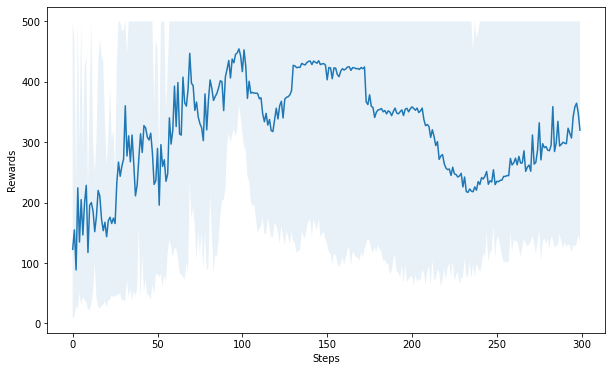

In [13]:
idxs = range(max_episodes)
fig, ax = plt.subplots(1, figsize=(10,6))
ax.plot(idxs, test_rewards.mean(0))
ax.fill_between(idxs, test_rewards.min(0).values, test_rewards.max(0).values, alpha=0.1)
ax.set_xlabel('Steps')
ax.set_ylabel('Rewards');